## Import

In [1]:
import pandas as pd
import numpy as np
import re

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.inspection import PartialDependenceDisplay
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.utils.multiclass import unique_labels

import matplotlib.pyplot as plt

import joblib
import seaborn as sns



## Chargement des données

In [4]:
# Charger les données depuis le fichier CSV
df_final = pd.read_csv('../../Data/Preprocessed/catastrophes_naturelles_preprocessed.csv')
df_final.head()

,id,temperature,humidite,force_moyenne_du_vecteur_de_vent,force_du_vecteur_de_vent_max,pluie_intensite_max,sismicite,concentration_gaz,pluie_totale,catastrophe,Month,Day,quartier_1,quartier_2,quartier_3,quartier_4,quartier_5
0,0,0.465789,0.87237,0.086538,0.074653,0.0,0.457143,0.657992,0.182312,aucun,1,1,1,0,0,0,0
1,1,0.465789,0.87237,0.086538,0.074653,0.0,0.914286,0.741267,0.903308,seisme,1,1,0,1,0,0,0
2,2,0.465789,0.87237,0.086538,0.074653,0.0,0.928571,0.702983,0.363044,seisme,1,1,0,0,1,0,0
3,3,0.465789,0.87237,0.086538,0.074653,0.0,0.128571,0.295366,0.473939,aucun,1,1,0,0,0,1,0
4,4,0.465789,0.87237,0.086538,0.074653,0.0,0.157143,0.216245,0.475729,innondation,1,1,0,0,0,0,1


## Séparation des donné en train/test

In [5]:
# Séparer features et cible
X = df_final.drop(columns=['catastrophe', 'id']) 
y = df_final['catastrophe']

# Split train/test avec shuffle, stratify pour garder proportions classes
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    shuffle=True,
    random_state=42,
    stratify=y
)

## Création d'un pipeline de données et selection du meilleur modèle/hyperparamètre

In [6]:
pipe = Pipeline([
    ('model', RandomForestClassifier())
])

param_dist = [
    {
        'model': [RandomForestClassifier(random_state=42)],
        'model__n_estimators': [100, 200, 300, 400, 500],
        'model__max_depth': [None, 10, 20, 30, 40, 50],
        'model__min_samples_split': [2, 5, 10],
        'model__min_samples_leaf': [1, 2, 4],
        'model__max_features': ['sqrt', 'log2', None]
    },
    {
        'model': [GradientBoostingClassifier(random_state=42)],
        'model__n_estimators': [100, 200, 300, 400],
        'model__learning_rate': [0.001, 0.01, 0.05, 0.1, 0.2],
        'model__max_depth': [3, 5, 7, 9],
        'model__min_samples_split': [2, 5, 10],
        'model__min_samples_leaf': [1, 2, 4]
    },
    {
        'model': [LogisticRegression(max_iter=1000, random_state=42)],
        'model__C': np.logspace(-4, 4, 20),
        'model__penalty': ['l2'],
        'model__solver': ['lbfgs']
    },
    {
        'model': [SVC(random_state=42)],
        'model__C': np.logspace(-3, 3, 10),
        'model__kernel': ['linear', 'rbf', 'poly'],
        'model__gamma': ['scale', 'auto']
    }
]

random_search = RandomizedSearchCV(
    pipe,
    param_distributions=param_dist,
    n_iter=100,
    scoring='accuracy',
    cv=5,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train, y_train)

print("Best params:", random_search.best_params_)
print("Best cross-validation accuracy:", random_search.best_score_)

y_pred = random_search.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
print("Test set accuracy:", test_accuracy)


Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best params: {'model__n_estimators': 200, 'model__min_samples_split': 2, 'model__min_samples_leaf': 4, 'model__max_depth': 3, 'model__learning_rate': 0.01, 'model': GradientBoostingClassifier(random_state=42)}
Best cross-validation accuracy: 0.7676895179124281
Test set accuracy: 0.7664376840039254


## Sauvegarde du modèle

In [7]:
# Sauvegarder le modèle dans un fichier .joblib
joblib.dump(random_search.best_estimator_, '../../Data/Model/best_model.joblib')


['../../Data/Model/best_model.joblib']

## Evaluation du modèle

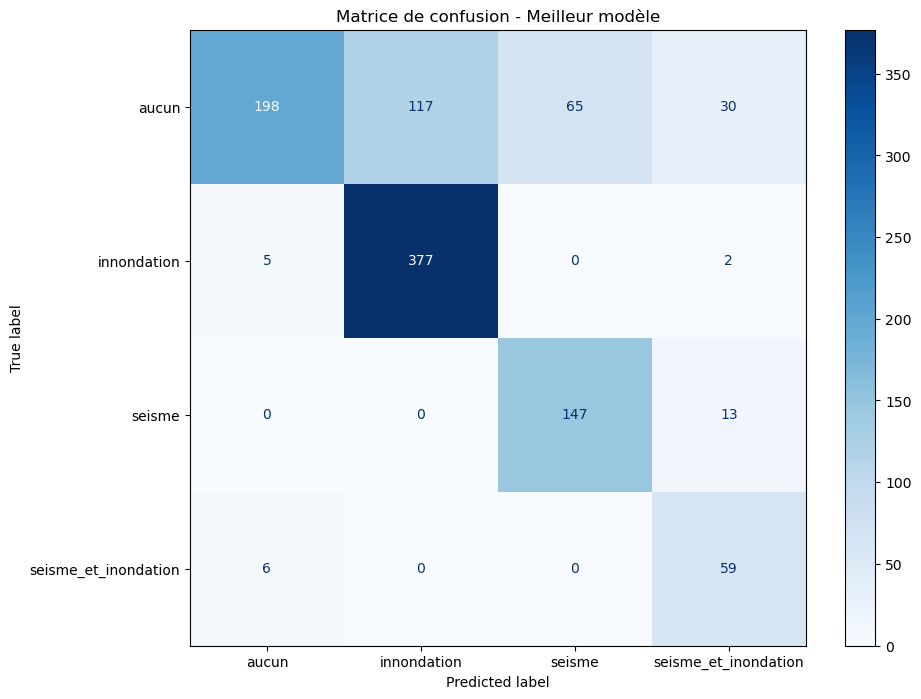

In [8]:
# Matrice de confusion
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=random_search.best_estimator_.named_steps['model'].classes_)

fig, ax = plt.subplots(figsize=(10,8))
disp.plot(ax=ax, cmap='Blues', colorbar=True)
plt.title("Matrice de confusion - Meilleur modèle")
plt.show()


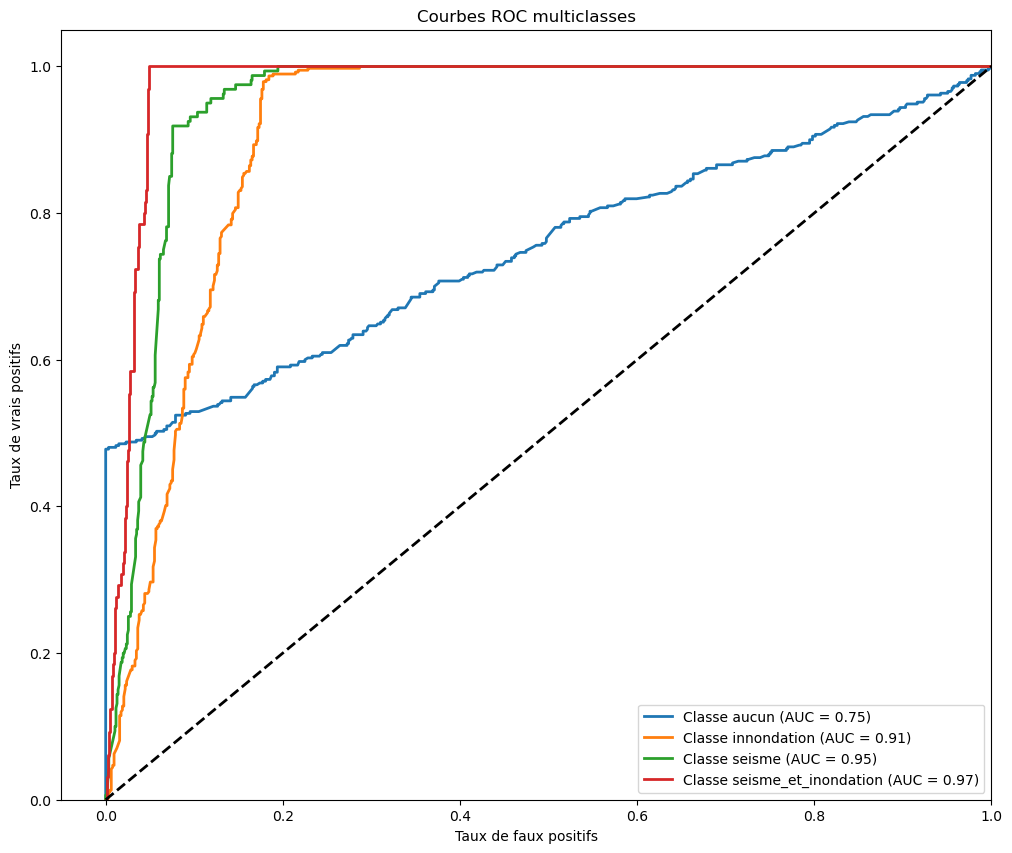

In [9]:
# Binariser les labels pour multiclass ROC
classes = unique_labels(y_test)
y_test_bin = label_binarize(y_test, classes=classes)
y_score = random_search.predict_proba(X_test)

plt.figure(figsize=(12,10))

for i, class_label in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'Classe {class_label} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.title('Courbes ROC multiclasses')
plt.legend(loc="lower right")
plt.show()


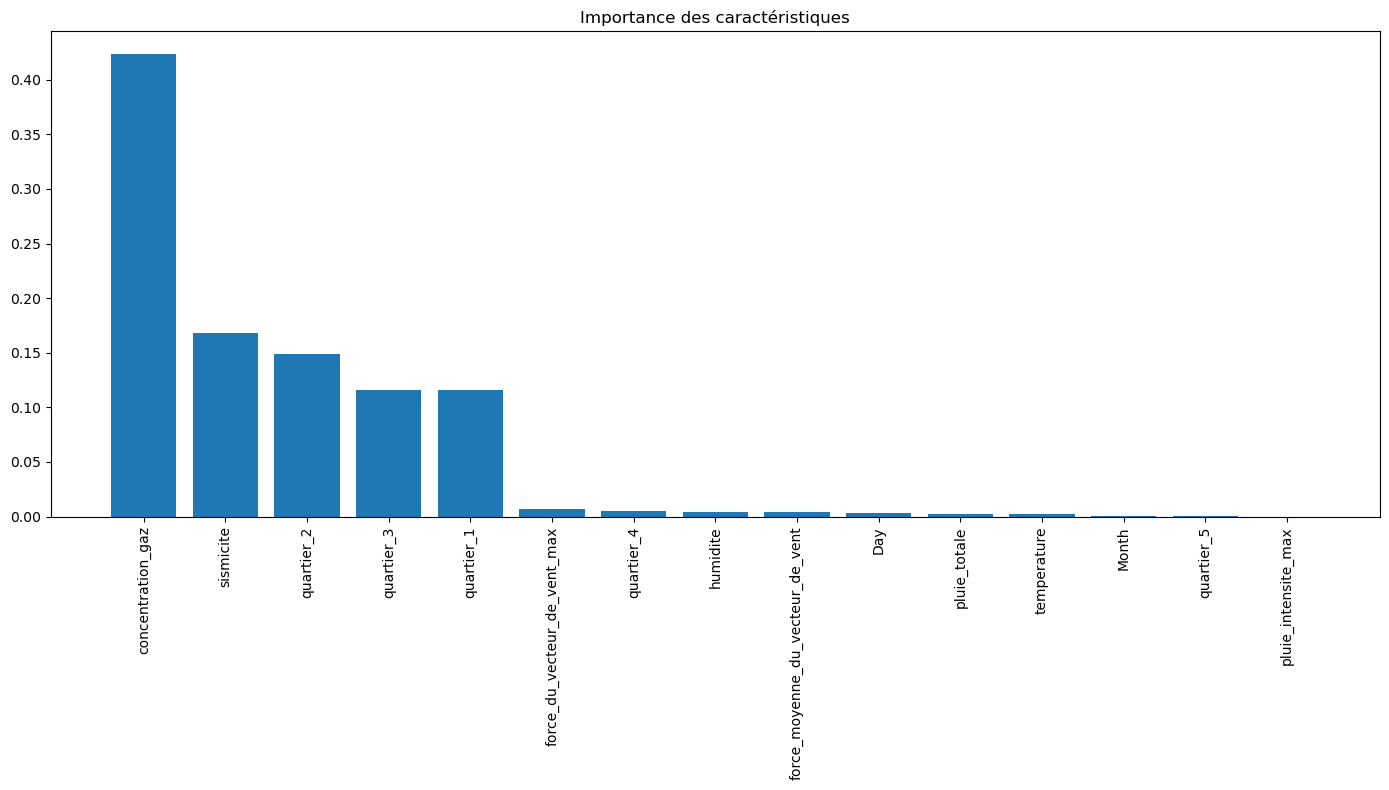

In [10]:
importances = random_search.best_estimator_.named_steps['model'].feature_importances_
features = X_train.columns

indices = importances.argsort()[::-1]

plt.figure(figsize=(14,8))
plt.title("Importance des caractéristiques")
plt.bar(range(len(importances)), importances[indices], align='center')
plt.xticks(range(len(importances)), features[indices], rotation=90)
plt.tight_layout()
plt.show()


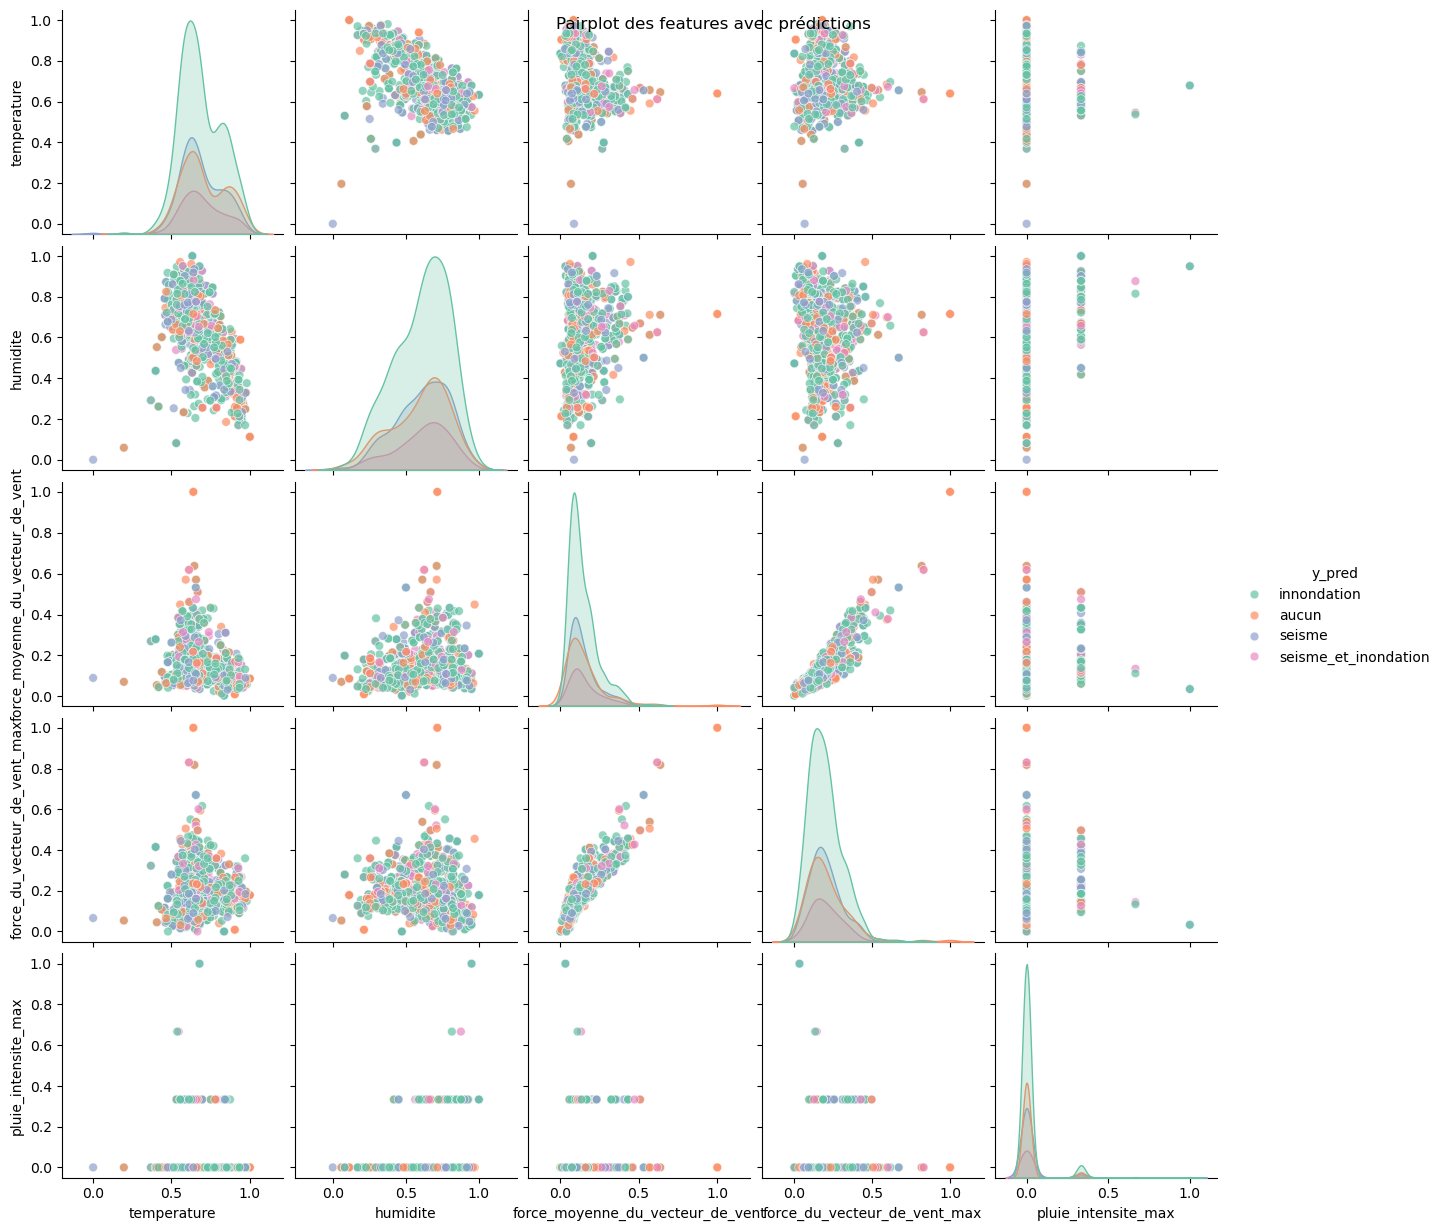

In [11]:
X_test_df = pd.DataFrame(X_test, columns=X_train.columns)
X_test_df['y_true'] = y_test
X_test_df['y_pred'] = y_pred

sns.pairplot(
    X_test_df,
    hue='y_pred',
    vars=X_train.columns[:5],
    palette='Set2',
    plot_kws={'alpha':0.7, 's':40}
)
plt.suptitle('Pairplot des features avec prédictions')
plt.show()
